In [215]:
import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

print(torch.__version__,torch.cuda.is_available())

2.6.0+cu124 True


In [ ]:
transform = transforms.Compose([
    transforms.Resize((28,28)),  # Resize all images to 28x28
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])


train_data = datasets.Flowers102(root="data",
                              split="train",
                              download=True,
                              transform=transform,
                              target_transform=None)


test_data = datasets.Flowers102(root="data",
                              split="test",
                              download=True,
                              transform=transform,
                              target_transform=None)
train_data,test_data

(Dataset Flowers102
     Number of datapoints: 1020
     Root location: data
     split=train
     StandardTransform
 Transform: Compose(
                Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
                Grayscale(num_output_channels=1)
                ToTensor()
            ),
 Dataset Flowers102
     Number of datapoints: 6149
     Root location: data
     split=test
     StandardTransform
 Transform: Compose(
                Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
                Grayscale(num_output_channels=1)
                ToTensor()
            ))

In [88]:
class_names = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea", 
    "wild geranium", "tiger lily", "moon orchid", "bird of paradise", "monkshood", 
    "globe thistle", "snapdragon", "colt's foot", "king protea", "spear thistle", 
    "yellow iris", "globe flower", "purple coneflower", "peruvian lily", "balloon flower", 
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary", "red ginger", 
    "grape hyacinth", "corn poppy", "prince of wales feathers", "stemless gentian", 
    "artichoke", "sweet william", "carnation", "garden phlox", "love in the mist", 
    "mexican aster", "alpine sea holly", "ruby-lipped cattleya", "cape flower", 
    "great masterwort", "siam tulip", "lenten rose", "barbeton daisy", "daffodil", 
    "sword lily", "poinsettia", "bolero deep blue", "wallflower", "marigold", 
    "buttercup", "oxeye daisy", "common dandelion", "petunia", "wild pansy", 
    "primula", "sunflower", "pelargonium", "bishop of llandaff", "gaura", 
    "geranium", "orange dahlia", "pink-yellow dahlia?", "cautleya spicata", 
    "japanese anemone", "black-eyed susan", "silverbush", "californian poppy", 
    "osteospermum", "spring crocus", "bearded iris", "windflower", "tree poppy", 
    "gazania", "azalea", "water lily", "rose", "thorn apple", "morning glory", 
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani", "clematis", 
    "hibiscus", "columbine", "desert-rose", "tree mallow", "magnolia", 
    "cyclamen", "watercress", "canna lily", "hippeastrum", "bee balm", 
    "pink quill", "foxglove", "bougainvillea", "camellia", "mallow", 
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper", 
    "blackberry lily"
]


torch.Size([1, 28, 28])


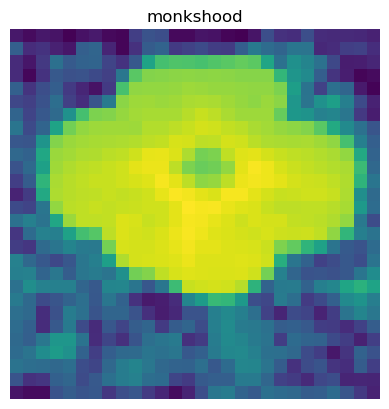

In [151]:
image,label = train_data[8]

# plt.figure(figsize=(15,5))
# plt.subplot(1,3,1)
# plt.imshow(image.squeeze()[0], cmap='gray')
# plt.title('Red Channel')
# plt.subplot(1,3,2)
# plt.imshow(image.squeeze()[1], cmap='gray')
# plt.title('Green Channel')
# plt.subplot(1,3,3)
# plt.imshow(image.squeeze()[2], cmap='gray')
# plt.title('Blue Channel')
plt.axis(False)
plt.title(class_names[8])
plt.imshow(image[0])
print(image.shape)

In [90]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)


test_dataloader = DataLoader(test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)


len(train_dataloader),len(test_dataloader)

(32, 193)

In [91]:
train_features_batch,train_labels_batch = next(iter(test_dataloader))
train_features_batch.shape,train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

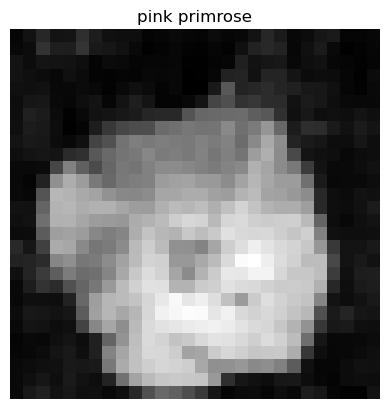

In [92]:
torch.manual_seed(42)
train_idx = torch.randint(0,len(train_features_batch),size=[1]).item()
img,label = train_features_batch[train_idx], train_labels_batch[train_idx]
plt.imshow(img.squeeze(),cmap="gray")
plt.title(class_names[label])
plt.axis(False)

In [93]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

print(f"Before Flattening {x.shape} ")
print(f"After Flattening {output.shape}")

Before Flattening torch.Size([1, 28, 28]) 
After Flattening torch.Size([1, 784])


In [94]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [95]:
class FlowerModelBase(nn.Module):
    
    def __init__(self, input_shape,hidden_units,output_shape):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=output_shape)
        )
    
    def forward(self,x):
        return self.layers(x)
    

In [96]:
model_0 = FlowerModelBase(input_shape=28*28,hidden_units=10,output_shape=len(class_names)).to(device)
model_0

FlowerModelBase(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=102, bias=True)
  )
)

In [97]:
import requests
from pathlib import Path
github_file_link = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py"
if Path("helper_functions.py").is_file():
    print("File Already Exists, Skipping Download....")
else:
    response = requests.get(github_file_link)

    if response.status_code==200:
        with open("helper_functions.py","wb") as f:
            f.write(response.content)
    else:
        print("File Download Error")

File Already Exists, Skipping Download....


In [98]:
from helper_functions import accuracy_fn

accuracy_fn

<function helper_functions.accuracy_fn(y_true, y_pred)>

In [99]:
from timeit import default_timer as timer


def execution_time(start_time,end_time, device):
    total_time = end_time-start_time
    print(f"Train Time on {device} is {total_time:.4f}")
    return total_time

start_time = timer()

end_time = timer()

execution_time(start_time,end_time,"cpu")

Train Time on cpu is 0.0000


9.75700095295906e-06

In [100]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01)


In [103]:
from tqdm.auto import tqdm

torch.manual_seed(42)

train_time_on_cpu_start = timer()


epochs =1

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n")
    
    train_loss=0
    for batch,(X,y) in enumerate(train_dataloader):
        model_0.train()
        X,y = X.to(device),y.to(device)
        y_pred = model_0(X)
        
        loss = loss_fn(y_pred,y)
        
        train_loss +=loss
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        
        
        n = len(train_dataloader.dataset)
        if batch%20 == 0:
            print(f'Train Epoch: {epoch} [{batch * len(X)}/{n} '
                  f'({100. * batch / len(train_dataloader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    train_loss /= len(train_dataloader)
    
    
    test_loss,test_acc = 0,0
    
    model_0.eval()
    
    with torch.inference_mode():
        
        
        for X_test,y_test in test_dataloader:
            X_test,y_test = X_test.to(device),y_test.to(device)
            test_pred = model_0(X_test)
            
            test_loss+=loss_fn(test_pred,y_test)
            
            test_acc += accuracy_fn(y_test,test_pred.argmax(dim=1))
            
            test_loss/=len(test_dataloader)
            
            test_acc/=len(test_dataloader)
            

    print(f" Train Loss: {train_loss:.4f} || Test Loss {test_loss:.4f}")
    

train_time_on_cpu_end = timer()


exec_time = execution_time(train_time_on_cpu_start,train_time_on_cpu_end,str(next(model_0.parameters()).device))




  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0

Train Epoch: 0 [0/1020 (0%)]	Loss: 4.666233
Train Epoch: 0 [640/1020 (62%)]	Loss: 4.622321
 Train Loss: 4.6417 || Test Loss 0.0243
Train Time on cuda:0 is 14.1873


In [104]:
from helper_functions import accuracy_fn

acc_fn = accuracy_fn
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn,device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            
            X,y =X.to(device),y.to(device)
            y_pred = model(X)
            
            
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) 
        
        
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, 
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn,accuracy_fn=acc_fn,device=device)
model_0_results

{'model_name': 'FlowerModelBase',
 'model_loss': 4.637142181396484,
 'model_acc': 0.8095854922279793}

In [105]:
class FlowerModelSmall(nn.Module):
    
    def __init__(self, input_shape,hidden_units,output_shape):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape),
            nn.Sigmoid()
        )
    
    def forward(self,x):
        return self.layers(x)
    
    

In [209]:
from tqdm.auto import tqdm


torch.manual_seed(42)
def train_step(model,optimizer,loss_fn,train_dataloader,device):

    train_loss,train_acc=0,0
    for batch,(X,y) in enumerate(train_dataloader):
        X,y = X.to(device),y.to(device)
        model.train()
        
        y_pred = model(X)
        
        loss = loss_fn(y_pred,y)
        
        train_loss +=loss
        
        train_acc += accuracy_fn(y,y_pred.argmax(dim=1))
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    print(f" Train Loss: {train_loss:.4f} || Train Accuracy {train_acc:.2f}%")
    return train_loss,train_acc


def test_step(model,loss_fn,test_dataloader,device):
    test_loss,test_acc = 0.0,0
    
    model.eval()
    
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            X_test,y_test = X_test.to(device),y_test.to(device)
            test_pred = model(X_test)
            
            test_loss+=loss_fn(test_pred,y_test)
            
            test_acc += accuracy_fn(y_test,test_pred.argmax(dim=1))
            
        test_loss/=len(test_dataloader)
        
        test_acc/=len(test_dataloader)

    print(f" Test Loss: {test_acc:.4f} || Test Accuracy {test_acc:.2f}%")


In [110]:
from timeit import default_timer as timer



model_1 = FlowerModelSmall(input_shape=784,hidden_units=10,output_shape=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(),lr=0.01)


train_time_on_gpu_start = timer()
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n")
    
    train_step(model_1,optimizer,loss_fn,train_dataloader,device)
    test_step(model_1,loss_fn,test_dataloader,device)    
    
    
train_time_on_gpu_end = timer()


total_train_time_model_1 = execution_time(train_time_on_gpu_start,train_time_on_gpu_end,device)
total_train_time_model_1

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0

 Train Loss: 4.6269 || Train Accuracy 1.0742
 Test Loss: 0.8420 || Test Accuracy 0.8420
Epoch 1

 Train Loss: 4.6267 || Train Accuracy 1.0882
 Test Loss: 0.8420 || Test Accuracy 0.8420
Epoch 2

 Train Loss: 4.6265 || Train Accuracy 0.9766
 Test Loss: 0.8905 || Test Accuracy 0.8905
Train Time on cuda is 41.8606


41.86063159300102

In [111]:
model_1_results = eval_model(model_1,test_dataloader,loss_fn,acc_fn,device)
model_1_results

{'model_name': 'FlowerModelSmall',
 'model_loss': 4.625186443328857,
 'model_acc': 0.8905440414507773}

In [112]:
!nvidia-smi

Mon Apr 28 19:40:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P0             17W /   80W |     821MiB /   8188MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [113]:
model_0_results,model_1_results

({'model_name': 'FlowerModelBase',
  'model_loss': 4.637142181396484,
  'model_acc': 0.8095854922279793},
 {'model_name': 'FlowerModelSmall',
  'model_loss': 4.625186443328857,
  'model_acc': 0.8905440414507773})

In [192]:

class FlowerModelCNNBase(nn.Module):
    def __init__(self,input_shape,hidden_units,output_shape):
        super(FlowerModelCNNBase,self).__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      padding=1,
                      stride=1,
                      kernel_size=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      padding=1,
                      stride=1,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      padding=1,
                      stride=1,
                      kernel_size=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      padding=1,
                      stride=1,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*6*6,
                      out_features=output_shape),
        )

    def forward(self,x):
        x = x.to(device)
        x = self.conv_block_1(x)
        # print(x.shape)
        
        x = self.conv_block_2(x)
        # print(x.shape)
        
        x = self.classifier(x)
        
        return x
        

In [193]:
image.shape

torch.Size([1, 28, 28])

In [204]:
# img = train_data[0][0].unsqueeze(0)
# model_2(img)
# print(train_data[0][0].shape,train_data[0][0].unsqueeze(0).shape)


In [205]:
# dummy_image = torch.rand([10,1,64,64])
# img,label  = train_data[0]
# print(img.shape)

# plt.imshow(img[0],cmap="gray")

In [ ]:
torch.manual_seed(42)


conv_layer =nn.Conv2d(in_channels=1,
                      out_channels=10,
                      padding=10,
                      stride=10,
                      kernel_size=10)

conv_output = conv_layer(img.unsqueeze(0))

conv_output.shape

torch.Size([1, 10, 4, 4])

In [206]:
from helper_functions import accuracy_fn
torch.manual_seed(42)

model_2 = FlowerModelCNNBase(input_shape=1,
                             hidden_units=10,
                             output_shape=len(class_names)).to(device)

optimizer = torch.optim.SGD(params=model_2.parameters(),lr=0.1)
loss_fn = nn.CrossEntropyLoss()

In [210]:
epochs = 10



cnn_start_time = timer()
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}\n......")
    train_step(model_2,optimizer,loss_fn,train_dataloader,device)
    test_step(model_2,loss_fn,test_dataloader,device)
    

cnn_end_time = timer()


exec_time = execution_time(cnn_start_time,cnn_end_time,str(next(model_2.parameters()).device)) 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1
......
 Train Loss: 4.6267 || Train Accuracy 0.68%
 Test Loss: 0.5505 || Test Accuracy 0.55%
Epoch 2
......
 Train Loss: 4.6267 || Train Accuracy 0.39%
 Test Loss: 2.0078 || Test Accuracy 2.01%
Epoch 3
......
 Train Loss: 4.6267 || Train Accuracy 0.70%
 Test Loss: 0.6315 || Test Accuracy 0.63%
Epoch 4
......
 Train Loss: 4.6266 || Train Accuracy 0.88%
 Test Loss: 0.3886 || Test Accuracy 0.39%
Epoch 5
......
 Train Loss: 4.6265 || Train Accuracy 0.88%
 Test Loss: 0.5181 || Test Accuracy 0.52%
Epoch 6
......
 Train Loss: 4.6264 || Train Accuracy 0.68%
 Test Loss: 2.0887 || Test Accuracy 2.09%
Epoch 7
......
 Train Loss: 4.6263 || Train Accuracy 0.98%
 Test Loss: 1.5220 || Test Accuracy 1.52%
Epoch 8
......
 Train Loss: 4.6261 || Train Accuracy 0.59%
 Test Loss: 1.1010 || Test Accuracy 1.10%
Epoch 9
......
 Train Loss: 4.6259 || Train Accuracy 0.68%
 Test Loss: 1.5382 || Test Accuracy 1.54%
Epoch 10
......
 Train Loss: 4.6256 || Train Accuracy 0.49%
 Test Loss: 1.1658 || Test Accu

In [213]:
!nvidia-smi

Mon Apr 28 23:21:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P3              9W /   80W |     770MiB /   8188MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [212]:
model_2_results = eval_model(model_2,test_dataloader,loss_fn,accuracy_fn,device)

model_0_results,model_1_results,model_2_results

({'model_name': 'FlowerModelBase',
  'model_loss': 4.637142181396484,
  'model_acc': 0.8095854922279793},
 {'model_name': 'FlowerModelSmall',
  'model_loss': 4.625186443328857,
  'model_acc': 0.8905440414507773},
 {'model_name': 'FlowerModelCNNBase',
  'model_loss': 4.623857498168945,
  'model_acc': 1.16580310880829})

Text(0, 0.5, 'model')

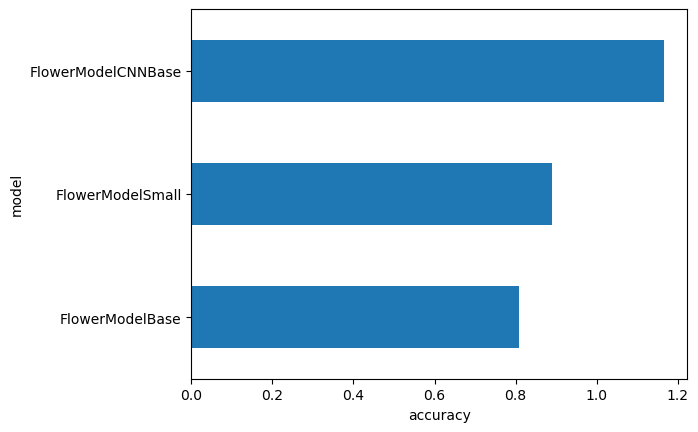

In [219]:
overall_results = pd.DataFrame(
    [model_0_results,model_1_results,model_2_results]
)

overall_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy")
plt.ylabel("model")